# Explainable AI con algoritmi genetici

In questo notebook si prova ad analizzare un possibile approccio genetico
a problemi di explainable AI, cercando di spiegare un classificatore **Random
Forest**. Non ci interessa sapere se la classificazione sia corretta o meno ma
solo:

- "Perché" i dati sono stati classificati in quel modo dal modello.
- Come modificare i dati in modo che varino il meno possibile ma vengano
  classificati in modo differente.

Prendiamo come riferimento un problema semplice in cui abbiamo punti definiti
da 2 sole feature e che possono essere classificati in soli 2 modi.

## Roadmap

Iniziamo con il definire ad alto livello l'algoritmo completo:

1. Training di un modello di classificazione Random Forest o MLP.
2. Classificazione di punti non presenti nel training set.
3. Esecuzione dell'algoritmo genetico su ogni punto classificato.
4. Analisi dei fattuali cercando un grado di incertezza nella classificazione.
5. Analisi dei controfattuali valutando quanti individui sintetici sono
   riusciti a cambiare classe e, nel caso ci siano riusciti, misurazione della
   differenza nel valore delle feature.


In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification


X, y = make_classification(
    n_samples=200,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=1,
    shuffle=True,
    random_state=0,
)

df = pd.DataFrame({"feature1": X.T[0], "feature2": X.T[1], "class": y})
df

,feature1,feature2,class
0,1.070334,-0.929154,1
1,-0.475656,1.278883,0
2,0.885906,1.690195,1
3,1.365818,1.077153,1
4,-1.260713,0.895089,0
...,...,...,...
195,0.858270,2.063549,1
196,0.628935,2.615793,1
197,0.359017,-1.073006,1
198,-0.521872,0.578906,0


Proseguiamo con il dividere il dataset in training set e test set. Di seguito
un plot del training set.


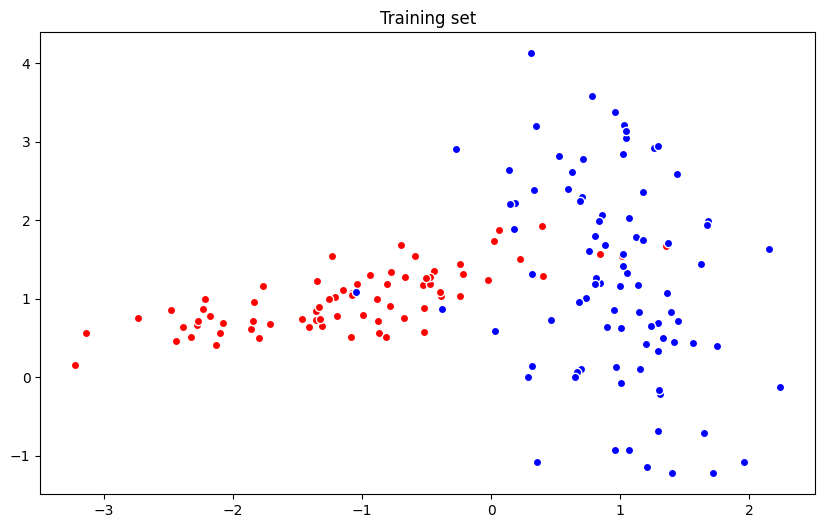

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

cls0 = [i for i in range(len(y_train)) if y_train[i] == 0]
cls1 = [i for i in range(len(y_train)) if y_train[i] == 1]

cmap = plt.get_cmap("Set1")
plt.figure(figsize=(10, 6))
plt.title("Training set")
plt.scatter(X_train.T[0][cls0], X_train.T[1][cls0], c="r", ec="w")
plt.scatter(X_train.T[0][cls1], X_train.T[1][cls1], c="b", ec="w")
plt.show()

Abbiamo quindi un training set e un test set su cui allenare e testare il
modello rispettivamente. Più precisamente non sfrutteremo la parte di test set
che ci fornisce la classe giusta per i punti classificati. Non è di nostro
interesse infatti testare la correttezza del modello.

Proseguiamo quindi con l'allenamento del modello e la classificazione dei nuovi
punti i quali diventeranno centrali nella nostra analisi.


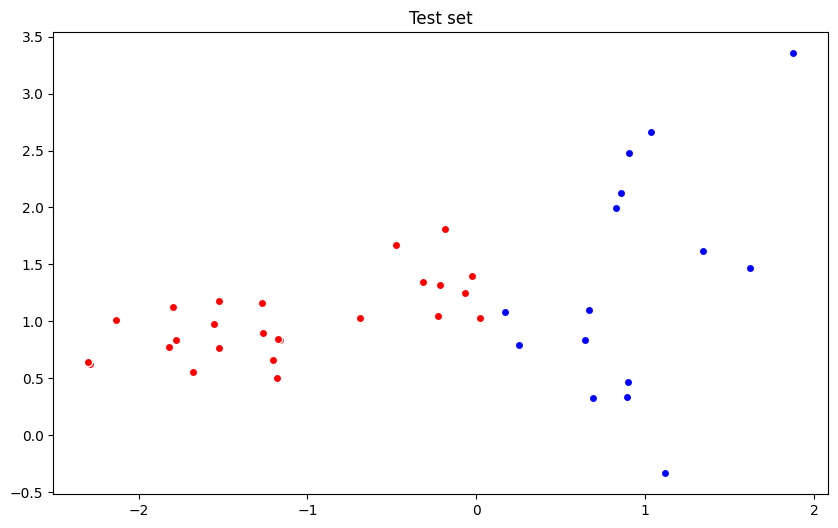

In [3]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
y_predicted = classifier.predict(X_test)

cls0 = [i for i in range(len(y_predicted)) if y_predicted[i] == 0]
cls1 = [i for i in range(len(y_predicted)) if y_predicted[i] == 1]

plt.figure(figsize=(10, 6))
plt.title("Test set")
plt.scatter(X_test[cls0].T[0], X_test[cls0].T[1], c="r", ec="w")
plt.scatter(X_test[cls1].T[0], X_test[cls1].T[1], c="b", ec="w")
plt.show()

A questo punto prendiamo a caso uno dei punti classificati, di seguito
rappresentato con una X.


point: (0.17047, 1.08044)
class: 1


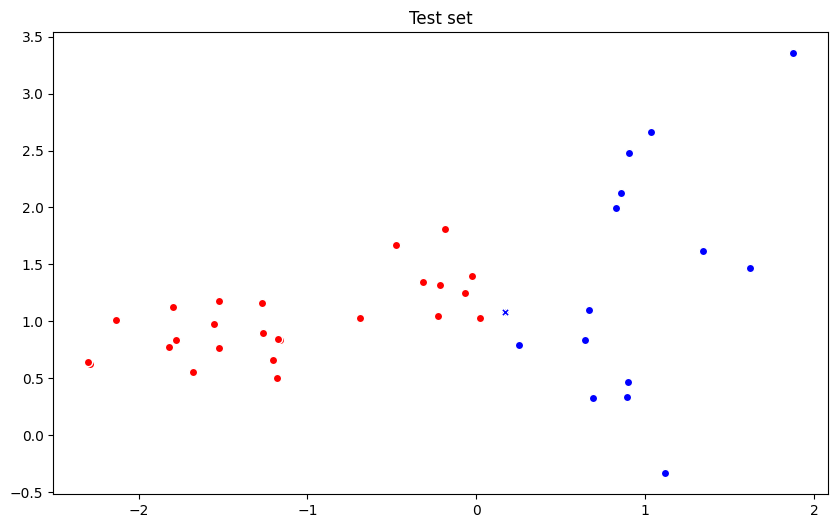

In [4]:
plt.figure(figsize=(10, 6))
plt.title("Test set")
plt.scatter(X_test[cls0].T[0], X_test[cls0].T[1], c="r", ec="w")
plt.scatter(X_test[cls1].T[0], X_test[cls1].T[1], c="b", ec="w")

point = X_test[7]
print(f"point: ({point[0]:.5f}, {point[1]:.5f})")
point_class = y_predicted[7]
print(f"class: {point_class}")

c = "r" if point_class == 0 else "b"
plt.scatter(point[0], point[1], c=c, ec="w", marker="X")
plt.show()

## Algoritmo genetico

L'algoritmo genetico prevede di analizzare ogni singolo punto un numero di
volte pari al numero delle classi possibili (nel nostro caso 2). Andremo a
definire due approcci volti a risolvere due problemi differenti:

1. Spiegare perché quel punto è stato classificato in un determinato modo.
2. Capire come modificare le feature di quel punto il meno possibile per
   riuscire a classificarlo in tutte le altre possibili classi.

Come forma del cromosoma abbiamo semplicemente il vettore delle feature di
ciascun individuo.

### Generazione della popolazione iniziale

Come in ogni algoritmo genetico c'è bisogno di andare a generare una
popolazione iniziale. Nel nostro caso abbiamo bisogno che la popolazione
iniziale sia generata in modo che i nuovi individui siano simili a quello di
riferimento.

Per riuscire a generare una popolazione con queste caratteristiche possiamo
sfruttare la deviazione standard di ogni feature per generare un offset
coerente con il dataset che stiamo considerando su ogni asse.


In [5]:
sigma = X_test.std(axis=0)
sigma

array([1.17144131, 0.6751292 ])

Per generare punti sintetici intorno a quello di riferimento usiamo due
possibili distribuzioni

- **Uniforme**: si ottiene una popolazione sintetica equamente distribuita su
  ogni asse sfruttando un parametro $\alpha \in [0, 1]$ per regolare l'ampiezza
  dell'intervallo di valori. Intervallo definito in funzione della deviazione
  standard di ognuna delle feature. Avremo quindi che per ogni feature, lo
  spazio entro cui vengono generate le feature dei punti sintetici è il
  seguente
  $$[x_i - \sigma_i \cdot \alpha, \; x_ i + \sigma_i \cdot \alpha]$$
  dove $x_i$ è il valore dell'$i$-esima feature per il punto $x$ e $\sigma_i$ è
  la deviazione standard dell'$i$-esima feature rispetto a tutta la popolazione.
- **Normale**: in modo simile possiamo usare una distribuzione normale centrata
  nel valore della feature e usare sempre una frazione della deviazione
  standard piccola a piacere. Avremo quindi una distribuzione del tipo:
  $$N(x_i, \; \sigma_i \cdot \alpha)$$
  in cui $x_i$ è il valore dell'$i$-esima feature e $\sigma_i$ la sua
  deviazione standard.

Una distribuzione normale dovrebbe avere il vantaggio di riuscire a scalare
con la stessa dispersione che ha popolazione intera, mantenendo le
caratteristiche delle distribuzione di punti iniziale.

Una distribuzione uniforme invece riempe uno spazio arbitrariamente grande e
ben definito intorno al punto di riferimento. Potrebbe però non rispecchiare
la distribuzione dei punti del dataset di riferimento. Lo spazio entro il quale
vengono generati i punti tenderà inoltre ad avere una forma rettangolare se si
genera un numero sufficiente di punti.


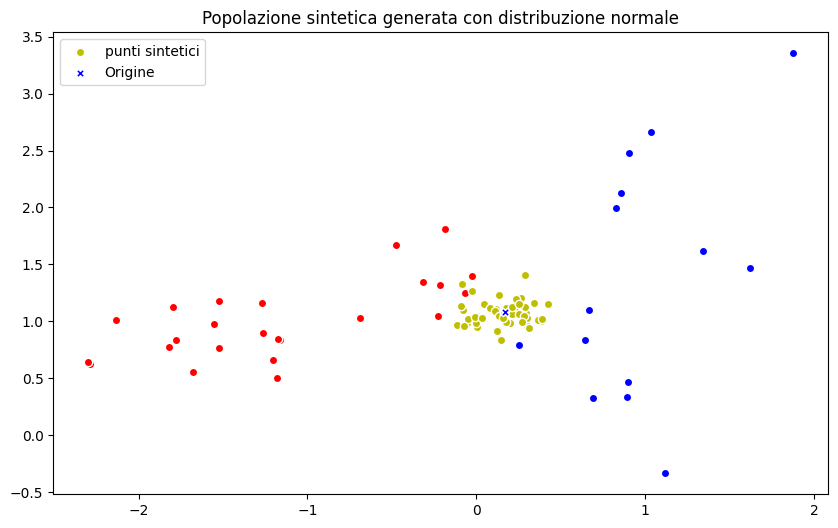

In [6]:
from numpy import random
from ppga import base


def generate_normal(point, sigma, alpha: float) -> np.ndarray:
    return random.normal(point, alpha * sigma, size=(2,))


def generate_uniform(point, sigma, alpha: float) -> np.ndarray:
    return random.uniform(point - sigma * alpha, point + sigma * alpha, size=(2,))


toolbox = base.ToolBox()
toolbox.set_generation(generate_normal, point=point, sigma=sigma, alpha=0.15)

# generazione di una popolazione composta da 50 individui
population = toolbox.generate(50)
synth_points = np.array([i.chromosome for i in population])

plt.figure(figsize=(10, 6))
plt.title("Popolazione sintetica generata con distribuzione normale")
plt.scatter(X_test[cls0].T[0], X_test[cls0].T[1], c="r", ec="w")
plt.scatter(X_test[cls1].T[0], X_test[cls1].T[1], c="b", ec="w")

plt.scatter(
    synth_points.T[0], synth_points.T[1], c="y", ec="w", label="punti sintetici"
)

c = "r" if point_class == 0 else "b"
plt.scatter(point[0], point[1], c=c, ec="w", marker="X", label="Origine")

plt.legend()
plt.show()

### Crossover

Gli operatori di crossover da testare sono principalmente due:

- **One point** o **Two Points**: questi due operatori andrebbero a mischiare
  le feature dei due individui lasciandole invariate, sarà poi compito
  dell'operatore di mutazione effettuare variazioni sui valori stessi.
- **Media e fattore stocastico**: in alternativa si potrebbero creare due figli
  le cui feature sono la media delle feature dei genitori. Dato che sarebbero
  due figli uguali si potrebbe aggiungere un termine casuale per differenziarli.
  In alternativa si potrebbe generare un solo figlio da ogni coppia.

Per i test andremo ad usare un semplice _one point crossover_.


In [7]:
def cx_one_point(father, mother):
    cx_point = random.randint(1, len(father))

    offspring1 = np.append(father[:cx_point], mother[cx_point:])
    offspring2 = np.append(mother[:cx_point], father[cx_point:])

    return offspring1, offspring2


toolbox.set_crossover(cx_one_point)
o1, o2 = toolbox.crossover(population[0], population[1])
print(f"father: {population[0].chromosome}")
print(f"mother: {population[1].chromosome}")
print(f"offspring 1: {o1.chromosome}")
print(f"offspring 2: {o2.chromosome}")

father: [0.20164155 0.98910907]
mother: [-0.08078321  1.09631887]
offspring 1: [0.20164155 1.09631887]
offspring 2: [-0.08078321  0.98910907]


Come possiamo vedere con due features andiamo semplicemente ad incrociare i
valori di padre e madre per generare due figli. Il problema di questo crossover
è che da solo non genera mai nuovi valori per le feature ma va ad esplorare
le possibili permutazioni dei valori già esistenti.

### Mutazione

L'operatore di mutazione andrà a modificare ogni feature di un termine
stocastico con una certa probabilità. Tale termine viene generato casualmente
tramite una distribuzione gaussiana
$$N(x_i, \; \alpha \cdot \sigma_i)$$
centrata nel valore della feature $i$-esima ($x_i$) e con deviazione standard
una frazione ($\alpha$) della deviazione standard di quella feature calcolata
sull'intera popolazione ($\sigma_i$).


In [8]:
def mut_gaussian(individual, sigma, alpha: float = 0.05, indpb: float = 0.2):
    for i, f in enumerate(individual):
        if random.random() <= indpb:
            individual[i] = random.normal(loc=f, scale=sigma[i] * alpha)

    return individual


toolbox.set_mutation(mut_gaussian, sigma, 0.15, 0.8)
print(o1)
o1 = toolbox.mutate(o1)
print(o1)

[0.20164155 1.09631887]: 0.0
[-0.01190774  1.06928941]: 0.0


L'operatore richiede quindi la deviazione standard di tutte le feature
calcolata sull'intera popolazione, un parametro $\alpha$ che regola l'intesità
della mutazione e la probabilità che ogni singola feature ha di essere mutata.

### Funzione di valutazione

La funzione di valutazione è certamente uno dei punti più importanti. Nello 
specifico ci serviranno due funzioni differenti:

- La prima funzione ci serve nel caso in cui si voglia rimanere nella stessa
  classe del punto di riferimento.
- La seconda funzione ci serve invece quando si vuole cambiare la classe dei
  punti sintetici in una classe specifica, diversa da quella di partenza.

Il valore di fitness in sé dipende molto dalla **distanza euclidea** tra i
due punti. Sebbene in entrambi i casi l'obbiettivo sia minimizzare la distanza
tra i punti sintetici e il punto d'origine, non vogliamo che questi si 
avvicinino troppo poiché non si otterrebbe alcuna informazione interessante.
Vogliamo infatti rimanere vicini ma mantenere un certo grado di esplorazione
dello spazio circostante.

Per risolvere questa situazione sarà sufficiente calcolare un certo valore 
$\epsilon$ sotto il quale la distanza non può scendere. Nel caso succeda la
il punto viene "respinto" di un $\epsilon$.

#### Stessa classe

L'obbiettivo della prima funzione di valutazione sarebbe quello di trovare
punti con una classificazione incerta. Se minimizzando la distanza si hanno
alcuni punti sintetici che sono valutati diversamente da come è valutato il
punto d'origine, significa che ci troviamo in una _zona di incertezza_.

In questo caso si potrebbe misurare il grado di incertezza del modello andando
a vedere, il rapporto tra i punti sintetici classificati diversamente dal punto
d'origine e quelli classificati come quest'ultimo.

Nel caso in cui tutti i punti siano classificati allo stesso modo del punto
d'origine, ci si può ritenere in una _zona sicura_, in cui il modello più
difficilmente riuscirà a cambiare la scelta che ha fatto. Potremo inoltre
ritenerci più _soddisfatti_ della classificazione, poiché sarà meno probabile
un eventuale condizionamento del modello, dovuto per esempio, ad un training
set sbilanciato.

##### Implementazione

In questo caso vogliamo definire una funzione che minimizzi la distanza andando
a premiare gli individui classificati come il punto d'origine.

Come anticipato, abbiamo bisogno di $\epsilon$ in grado di respingere gli
individui che si avvicinano troppo al punto di partenza. Per definire tale
valore possiamo usare un metodo simile a quello usato per la generazione.
Possiamo infatti far sì che ogni punto sintetico non si avvicini più di una
frazione della deviazione standard globale. In questo modo il valore $\epsilon$
cambia dinamicamente in funzione sia dell'ordine di grandezza delle feature,
sia della loro dispersione.

La differenza rispetto alla generazione dei punti sintetici è che non possiamo
considerare una deviazione standard separata per ogni feature dato che la
distanza è monodimensionale. Dobbiamo quindi calcolare la norma della
deviazione standard per ottenere un valore monodimensionale comparabile.

L'altro punto critico sta nell'assegnare un peso alla classificazione del punto
sintetico. Si potrebbe infatti ritenere più _pesante_ un punto sintetico con la 
stessa classe del punto d'origine e dare di conseguenza un peso minore a punti
con la stessa distanza ma classificati diversamente.

Ecco che entra in gioco un parametro $\alpha \in (0, 1)$ utile allo scopo.
Il coefficiente $\alpha$ di penalità assume un comportamento differente a
seconda di come viene classificato il punto sintetico. Va infatti a pesare
la distanza tra quest'ultimo e il punto d'origine in questo modo

$$
d(p_0, p_i) = \begin{cases}
    \| p_0 - p_i \| \cdot (1 - \alpha) & \text{se } C_0 = C_i \\
    \| p_0 - p_i \| \cdot \alpha & \text{altrimenti}
\end{cases}
$$

dove $p_0$ e $C_0$ sono rispettivamente il punto d'origine e la sua classe,
mentre $p_i$ e $C_i$ sono rispettivamente il punto sintetico che stiamo
valutando e la sua classe. Se il valore di $\alpha$ è maggiore di $0.5$, a
parità di distanza, i punti sintetici con classe $C_0$ vengono valutati meglio
di quelli classificati diversamente. Più grande è il valore di $\alpha$, più
accentutata sarà questa differenza.


In [9]:
from numpy import linalg


def same_evaluate(chromosome, point, classifier, epsilon: float, alpha: float = 0.5):
    assert alpha > 0.0 and alpha < 1.0

    # classification
    pt_class = classifier.predict(point.reshape(1, -1))
    synth_class = classifier.predict(chromosome.reshape(1, -1))

    # calcolo della distanza con norma euclidea
    distance = linalg.norm(chromosome - point, ord=2)

    # compute classification penalty
    same_class = 1 - alpha if pt_class == synth_class[0] else alpha

    # check the epsilon distance
    epsilon = 0.0 if same_class * distance > epsilon else epsilon

    return (same_class * distance + epsilon,)


toolbox.set_weights((-1.0,))
epsilon = linalg.norm(sigma * 0.025, ord=2)
toolbox.set_evaluation(same_evaluate, point, classifier, epsilon, 0.75)
population = list(map(toolbox.evaluate, population))

Abbiamo quindi una funzione che, oltre a parametri come il punto di
riferimento e il classificatore, ha bisogno di 2 parametri fondamentali:

- `epsilon`: valore di distanza minimo dal punto d'origine.
- `alpha`: coefficiente compreso tra 0 e 1. Indica il peso della
  classificazione del punto sintetico.

La scelta di entrambi i valori rimane a carico del programmatore, in quanto 
forniscono la base per analisi di tipo differente. Si potrebbe infatti avere
$\alpha = 0.5$ di modo da non condizionare l'esplorazione dello spazio di 
lavoro in base alla classificazione.

Al contrario, valori troppo alti di $\alpha$ porteranno ad avere una 
popolazione classificata solo in un modo. Capire se il punto si trova in una 
zona incerta sarà quindi il frutto di un'eventuale analisi successiva.


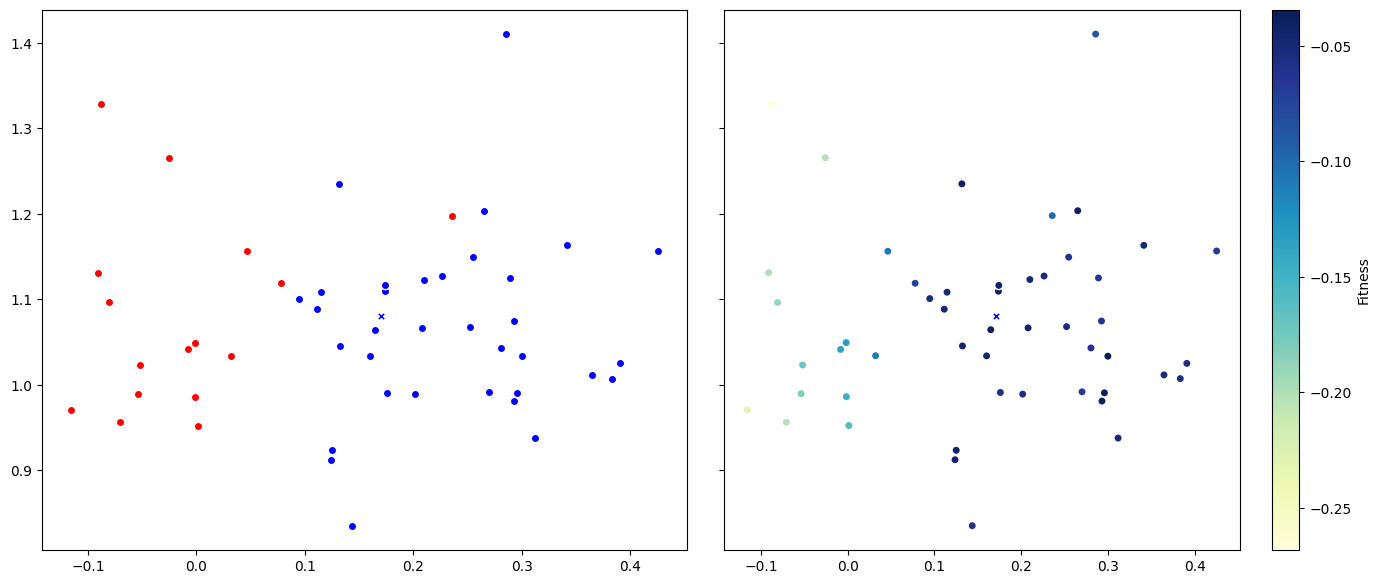

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6))
plt.tight_layout()

synth_classes = [classifier.predict(sp.reshape(1, -1)) for sp in synth_points]

scls0 = [i for i in range(len(synth_classes)) if synth_classes[i] == 0]
scls1 = [i for i in range(len(synth_classes)) if synth_classes[i] == 1]

# classification plot
ax1.scatter(synth_points[scls0].T[0], synth_points[scls0].T[1], c="r", ec="w")
ax1.scatter(synth_points[scls1].T[0], synth_points[scls1].T[1], c="b", ec="w")
ax1.scatter(point[0], point[1], c=c, ec="w", marker="X")

# fitness plot
fitness_values = [i.fitness for i in population]
sc = ax2.scatter(
    synth_points.T[0],
    synth_points.T[1],
    c=fitness_values,
    ec="w",
    cmap=plt.get_cmap("YlGnBu"),
)
fig.colorbar(sc, ax=ax2, label="Fitness")
ax2.scatter(point[0], point[1], c=c, ec="w", marker="X")

plt.show()

Anche solo visivamente dovrebbe essere possibile notare come, a parità di
distanza dal punto d'origine, i punti classificati diversamente da
quest'ultimo, abbiano un valore di fitness più basso.

A seconda di come viene generato il dataset e di come vengono disposti i punti
si potrebbe notare come 

#### Cambio di classe

Quando si vuole invece cambiare classe, il comportamento della funzione è 
leggermente diverso. Vogliamo infatti che i punti sintetici classificati in
$C_0$ si allontanino abbastanza da essere classificati in una **classe target** $C_t$. La funzione rimane praticamente la stessa con la differenza che ora 
dobbiamo fornire una classe target esplicitamente.

$$
d(p_0, p_i) = \begin{cases}
    \| p_0 - p_i \| \cdot (1 - \alpha) & \text{se } C_t = C_i \\
    \| p_0 - p_i \| \cdot \alpha & \text{altrimenti}
\end{cases}
$$

dove $C_t$ è la classe target a cui stiamo cercando di arrivare.


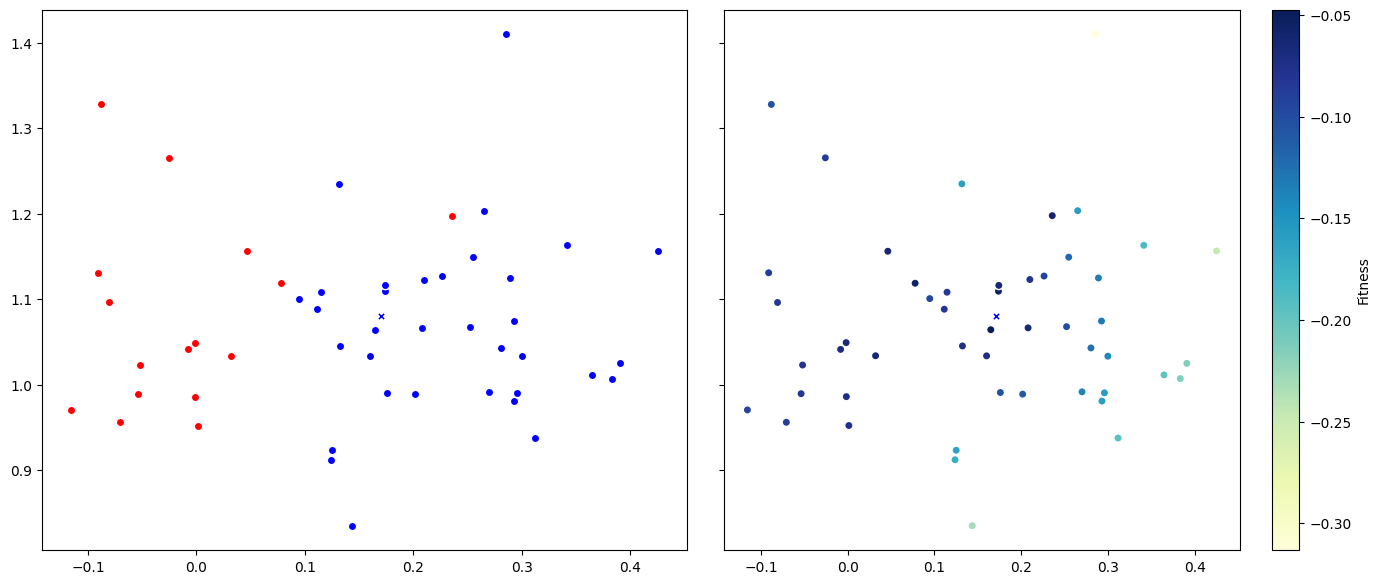

In [11]:
def other_evaluate(chromosome, point, target, classifier, epsilon: float, alpha: float = 0.5):
    assert alpha >= 0.0 and alpha < 1.0

    # classification
    synth_class = classifier.predict(chromosome.reshape(1, -1))

    # calcolo della distanza con norma euclidea
    distance = linalg.norm(chromosome - point, ord=2)

    # compute classification penalty
    target_class = 1 - alpha if target == synth_class[0] else alpha

    # check the epsilon distance
    epsilon = 0.0 if target * distance > epsilon else epsilon

    return (target_class * distance + epsilon,)


toolbox.set_weights((-1.0,))
target=(point_class + 1) % 2
toolbox.set_evaluation(other_evaluate, point, target, classifier, epsilon, 0.8)
population = list(map(toolbox.evaluate, population))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6))
plt.tight_layout()

synth_classes = [classifier.predict(sp.reshape(1, -1)) for sp in synth_points]

scls0 = [i for i in range(len(synth_classes)) if synth_classes[i] == 0]
scls1 = [i for i in range(len(synth_classes)) if synth_classes[i] == 1]

# classification plot
ax1.scatter(synth_points[scls0].T[0], synth_points[scls0].T[1], c="r", ec="w")
ax1.scatter(synth_points[scls1].T[0], synth_points[scls1].T[1], c="b", ec="w")
ax1.scatter(point[0], point[1], c=c, ec="w", marker="X")

# fitness plot
fitness_values = [i.fitness for i in population]
sc = ax2.scatter(
    synth_points.T[0],
    synth_points.T[1],
    c=fitness_values,
    ec="w",
    cmap=plt.get_cmap("YlGnBu"),
)
fig.colorbar(sc, ax=ax2, label="Fitness")
ax2.scatter(point[0], point[1], c=c, ec="w", marker="X")

plt.show()

### Simulazione 1

Entrambe le simulazioni verrano eseguite sullo stesso punto usato per gli
esempi. Per il momento ci occuperemo di effettuare una simulazione per la
prima casistica dell'algoritmo in cui cerchiamo di produrre individui simili
a quello iniziale e classificati allo stesso modo.

L'algoritmo usa una politica cosiddetta "elitista" regolata dal parametro
`keep`, il quale indica, in percentuale, quanta della vecchia generazione
vogliamo tenere. Nel nostro caso portiamo nella nuova generazione il 20%
dei migliori individui della vecchia generazione.


[INFO] CORE: 	gen            mean evals/worker
[INFO] CORE: 	0              26.000000      
[INFO] CORE: 	1              21.500000      
[INFO] CORE: 	2              17.000000      
[INFO] CORE: 	3              20.500000      
[INFO] CORE: 	4              20.000000      
[INFO] CORE: 	5              18.000000      
[INFO] CORE: 	6              22.000000      
[INFO] CORE: 	7              21.500000      
[INFO] CORE: 	8              21.000000      
[INFO] CORE: 	9              20.500000      
[INFO] CORE: 	10             20.000000      
[INFO] CORE: 	11             21.000000      
[INFO] CORE: 	12             21.500000      
[INFO] CORE: 	13             19.000000      
[INFO] CORE: 	14             20.500000      
[INFO] CORE: 	15             21.000000      
[INFO] CORE: 	16             21.000000      
[INFO] CORE: 	17             22.000000      
[INFO] CORE: 	18             21.000000      
[INFO] CORE: 	19             19.000000      
[INFO] CORE: 	20             19.500000      
[INFO] C

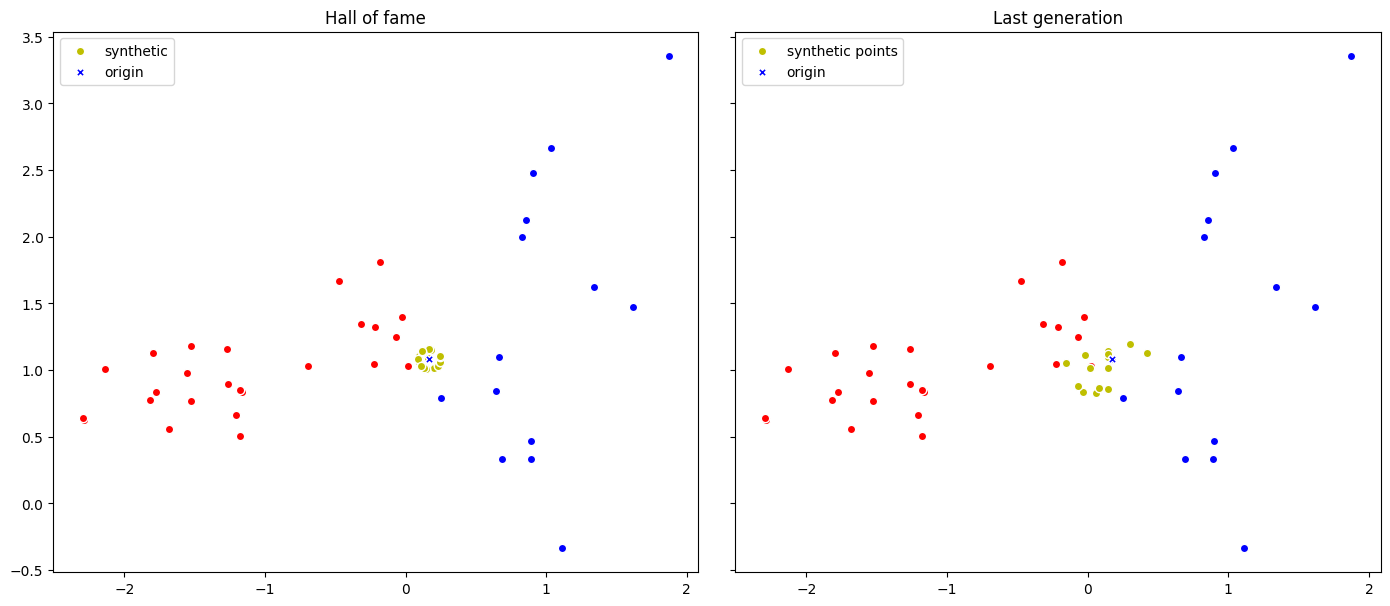

In [12]:
from ppga import tools, algorithms, log

toolbox.set_evaluation(same_evaluate, point, classifier, epsilon, 0.5)
toolbox.set_selection(tools.sel_tournament, tournsize=3)

hof = base.HallOfFame(50)
population, stats = algorithms.pelitist(
    toolbox=toolbox,
    population_size=100,
    keep=0.2,
    cxpb=0.8,
    mutpb=0.2,
    max_generations=50,
    hall_of_fame=hof,
    log_level=log.INFO,
)

hof_synth_points = np.array([i.chromosome for i in hof])
pop_synth_points = np.array([i.chromosome for i in population])

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6))
plt.tight_layout()

ax1.set_title("Hall of fame")
ax1.scatter(X_test[cls0].T[0], X_test[cls0].T[1], c="r", ec="w")
ax1.scatter(X_test[cls1].T[0], X_test[cls1].T[1], c="b", ec="w")

ax1.scatter(
    hof_synth_points.T[0], hof_synth_points.T[1], c="y", ec="w", label="synthetic"
)

c = "r" if point_class == 0 else "b"
ax1.scatter(point[0], point[1], c=c, ec="w", marker="X", label="origin")
ax1.legend()

ax2.set_title("Last generation")
ax2.scatter(X_test[cls0].T[0], X_test[cls0].T[1], c="r", ec="w")
ax2.scatter(X_test[cls1].T[0], X_test[cls1].T[1], c="b", ec="w")

ax2.scatter(
    pop_synth_points.T[0], pop_synth_points.T[1], c="y", ec="w", label="synthetic points"
)

c = "r" if point_class == 0 else "b"
ax2.scatter(point[0], point[1], c=c, ec="w", marker="X", label="origin")
ax2.legend()

plt.show()

#### Analisi

Svolgiamo dunque una semplice analisi andando a prendere dalla _Hall of Fame_
i migliori punti e dividiamoli per classe. Una volta suddivisi per classe 
possiamo andare a contare quanti punti abbiamo per ogni classe.

Una volta divisi i punti possiamo vedere quanti di questi sono classificati
come il punto di riferimento. In questo otteniamo un primo indice di precisione.

Tale indice andrebbe però interpretato più approfonditamente, tenendo di conto 
anche di altri parametri come ad esempio il valore di $\epsilon$. Con un
$\epsilon$ troppo piccolo è naturale infatti avere tutti i punti (o quasi)
classificati come il punto d'origine poiché saranno quasi sovrapposti a
quest'ultimo.

Altro parametro di cui tenere di conto è il peso $\alpha$ della classificazione.
Abbiamo infatti che per valori troppo alti di $\alpha$, l'algoritmo tenderà a
tagliare fuori gli individui classificati diversamente. La popolazione si
svilupperà infatti allontanandosi dal boundary di classificazione, riducendo 
molto la probabilità che ci siano punti classificati diversamente.


In [13]:
same_class = [i for i in hof if classifier.predict(i.chromosome.reshape(1, -1)) == point_class]
different_class = [i for i in hof if classifier.predict(i.chromosome.reshape(1, -1)) != point_class]

print(f"point of the same class: {len(same_class)}")
print(f"point of the other class: {len(different_class)}")
print(f"accuracy: {len(same_class) / len(hof) * 100.0:.2f}%")

point of the same class: 44
point of the other class: 6
accuracy: 88.00%


### Simulazione 2

Stavolta la simulazione verrà eseguita cercando di far cambiare classe ai punti
sintetici. In questo caso potrebbe essere giusto tenere un valore di $\alpha$
più alto poiché ci interessa che più punti possibile siano classificati nella 
classe target. I punti classificati diversamente da tale classe non sono di 
particolare interesse.


[INFO] CORE: 	gen            mean evals/worker
[INFO] CORE: 	0              26.000000      
[INFO] CORE: 	1              20.500000      
[INFO] CORE: 	2              20.500000      
[INFO] CORE: 	3              19.000000      
[INFO] CORE: 	4              18.000000      
[INFO] CORE: 	5              21.000000      
[INFO] CORE: 	6              21.000000      
[INFO] CORE: 	7              22.000000      
[INFO] CORE: 	8              21.000000      
[INFO] CORE: 	9              22.000000      
[INFO] CORE: 	10             21.500000      
[INFO] CORE: 	11             20.500000      
[INFO] CORE: 	12             21.500000      
[INFO] CORE: 	13             21.500000      
[INFO] CORE: 	14             18.500000      
[INFO] CORE: 	15             19.500000      
[INFO] CORE: 	16             20.500000      
[INFO] CORE: 	17             20.000000      
[INFO] CORE: 	18             20.000000      
[INFO] CORE: 	19             20.500000      
[INFO] CORE: 	20             20.500000      
[INFO] C

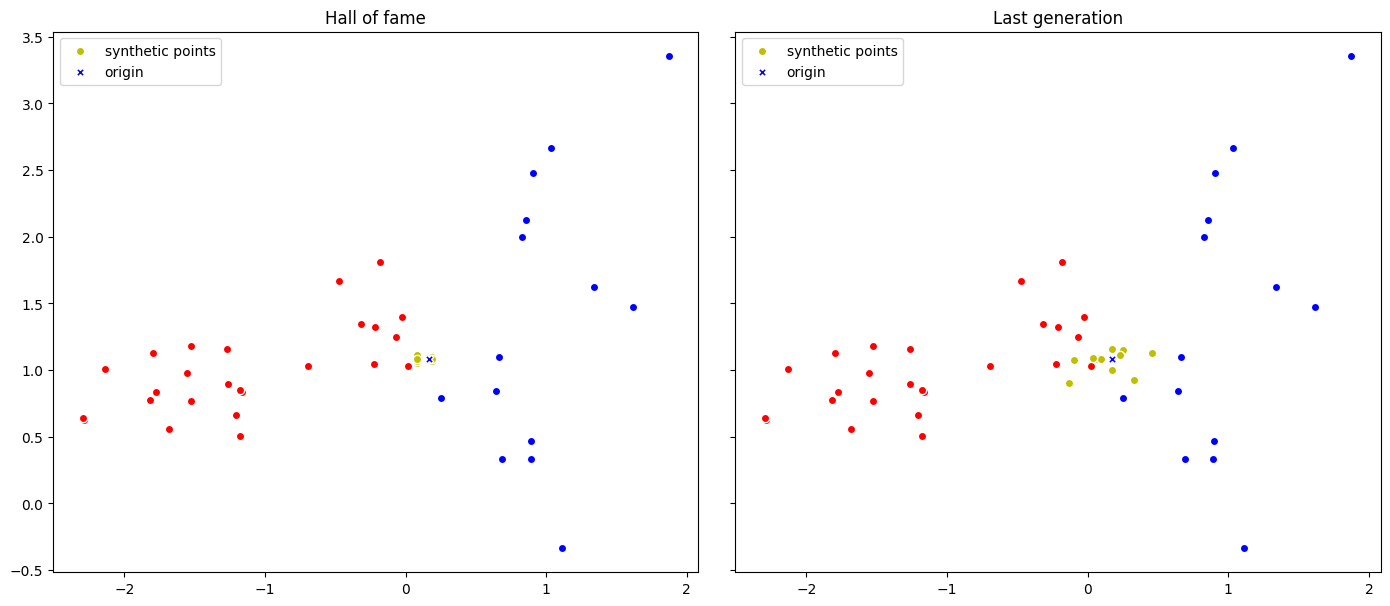

In [14]:
from ppga import tools, algorithms, log

target = (point_class + 1) % 2
toolbox.set_evaluation(other_evaluate, point, target, classifier, epsilon, 0.8)
toolbox.set_selection(tools.sel_tournament, tournsize=3)

hof = base.HallOfFame(50)
population, stats = algorithms.pelitist(
    toolbox=toolbox,
    population_size=100,
    keep=0.2,
    cxpb=0.8,
    mutpb=0.2,
    max_generations=50,
    hall_of_fame=hof,
    log_level=log.INFO,
)

hof_synth_points = np.array([i.chromosome for i in hof])
pop_synth_points = np.array([i.chromosome for i in population])

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6))
plt.tight_layout()

ax1.set_title("Hall of fame")
ax1.scatter(X_test[cls0].T[0], X_test[cls0].T[1], c="r", ec="w")
ax1.scatter(X_test[cls1].T[0], X_test[cls1].T[1], c="b", ec="w")

ax1.scatter(
    hof_synth_points.T[0], hof_synth_points.T[1], c="y", ec="w", label="synthetic points"
)

c = "r" if point_class == 0 else "b"
ax1.scatter(point[0], point[1], c=c, ec="w", marker="X", label="origin")
ax1.legend()

ax2.set_title("Last generation")
ax2.scatter(X_test[cls0].T[0], X_test[cls0].T[1], c="r", ec="w")
ax2.scatter(X_test[cls1].T[0], X_test[cls1].T[1], c="b", ec="w")

ax2.scatter(
    pop_synth_points.T[0], pop_synth_points.T[1], c="y", ec="w", label="synthetic points"
)

c = "r" if point_class == 0 else "b"
ax2.scatter(point[0], point[1], c=c, ec="w", marker="X", label="origin")
ax2.legend()

plt.show()

Come prima andiamo a dividere i punti sintetici per classe e andiamo
semplicemente a contare quanti di questi sono stati classificati nella classe
target rispetto al totale dei punti.


In [15]:
same_class = [i for i in hof if classifier.predict(i.chromosome.reshape(1, -1)) != target]
target_class = [i for i in hof if classifier.predict(i.chromosome.reshape(1, -1)) == target]

print(f"same class points: {len(same_class)}")
print(f"target class points: {len(target_class)}")
print(f"accuracy: {len(target_class) / len(hof) * 100.0:.2f}%")

same class points: 38
target class points: 12
accuracy: 24.00%


La Hall of Fame che ho implementato dovrebbe garantire diversità genetica
massima. Non in termini di differenza nei valori delle feature ma in termini 
di duplicati. Nella Hall of Fame non possono infatti esserci duplicati ed ha
una semantica simile a quella di un _set_ ordinato per fitness.
